In [103]:
import geopandas as gpd
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from gerrychain import constraints
from functools import partial
from gerrychain.tree import recursive_tree_part
import pickle
import random
import numpy.ma as ma

In [2]:
df = gpd.read_file("/cluster/tufts/mggg/jmatth03/DP/GA_bgs/GA_block_group_dp.shp")
graph = Graph.from_file("/cluster/tufts/mggg/jmatth03/DP/GA_bgs/GA_block_group_dp.shp")

In [196]:
df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,NH_2MOREsf,HISPsf,H_WHITEsf,H_BLACKsf,H_AMINsf,H_ASIANsf,H_NHPIsf,H_OTHERsf,H_2MOREsf,geometry
0,13,133,950303,4,131339503034,Block Group 4,G5030,S,22290817,2102661,...,3,72,11,0,0,0,1,59,1,"POLYGON ((-83.276416 33.57801, -83.27361999999..."
1,13,133,950200,2,131339502002,Block Group 2,G5030,S,30644092,141901,...,7,55,14,4,7,0,0,23,7,"POLYGON ((-83.115082 33.622705, -83.1146179999..."
2,13,133,950200,3,131339502003,Block Group 3,G5030,S,1165721,0,...,5,12,1,0,0,0,0,8,3,"POLYGON ((-83.08492299999999 33.622248, -83.08..."
3,13,133,950100,1,131339501001,Block Group 1,G5030,S,250282378,15397206,...,26,92,43,0,0,0,0,42,7,"POLYGON ((-83.40608999999999 33.69837, -83.404..."
4,13,133,950301,3,131339503013,Block Group 3,G5030,S,11161937,1443497,...,7,7,4,0,0,0,0,2,1,"POLYGON ((-83.245497 33.474029, -83.245041 33...."


In [54]:
total_pop = sum(df["TOTPOPsf"])

In [4]:
cong = np.load("/cluster/tufts/mggg/jmatth03/DP/data/GA_congress_100000.p")
sen = np.load("/cluster/tufts/mggg/jmatth03/DP/data/GA_state_senate_100000.p")

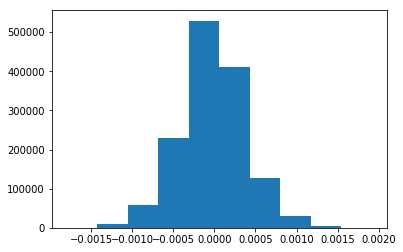

In [194]:
plt.hist((cong["BPOP_dp_perc"] - cong["BPOP_sf_perc"]).flatten())
plt.show()

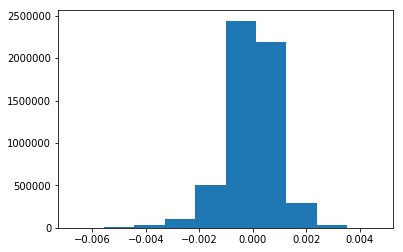

In [195]:
plt.hist((sen["BPOP_dp_perc"] - sen["BPOP_sf_perc"]).flatten())
plt.show()

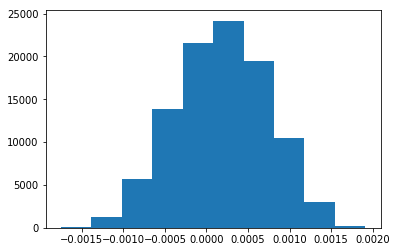

In [15]:
plt.hist(cong["BPOP_dp_perc"][:,-1] - cong["BPOP_sf_perc"][:,-1])
plt.show()

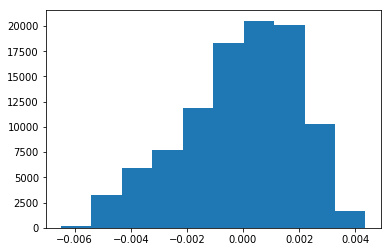

In [16]:
plt.hist(sen["BPOP_dp_perc"][:,-1] - sen["BPOP_sf_perc"][:,-1])
plt.show()

In [17]:
sen["BPOP_dp_perc"][:,-1]

array([0.8824798 , 0.8824798 , 0.8824798 , ..., 0.80071316, 0.80071316,
       0.80071316])

In [18]:
sen["BPOP_sf_perc"][:,-1]

array([0.88153987, 0.88153987, 0.88153987, ..., 0.80422104, 0.80422104,
       0.80422104])

In [152]:
cong_majbpop_dp = np.sum(cong["BPOP_dp_perc"] > 0.5, axis=1)
cong_majbpop_sf = np.sum(cong["BPOP_sf_perc"] > 0.5, axis=1)

sen_majbpop_dp = np.sum(sen["BPOP_dp_perc"] > 0.5, axis=1)
sen_majbpop_sf = np.sum(sen["BPOP_sf_perc"] > 0.5, axis=1)

In [210]:
x = cong_majbpop_dp - cong_majbpop_sf
print("Congress: # Majority-BPOP districts")
print("Mean diff: {}".format(np.mean(np.abs(x))))
print("Min diff: {}".format(np.min(x)))
print("Max diff: {}".format(np.max(x)))

x = sen_majbpop_dp - sen_majbpop_sf
print("\nState Senate: # Majority-BPOP districts")
print("Mean diff: {}".format(np.mean(np.abs(x))))
print("Min diff: {}".format(np.min(x)))
print("Max diff: {}".format(np.max(x)))

Congress: # Majority-BPOP districts
Mean diff: 0.00434
Min diff: -1
Max diff: 1

State Senate: # Majority-BPOP districts
Mean diff: 0.04057
Min diff: -2
Max diff: 2


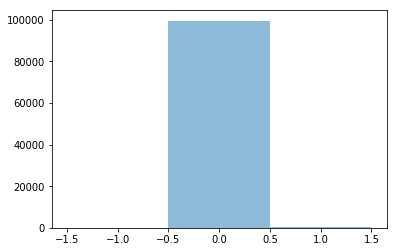

In [181]:
plt.hist(cong_majbpop_dp - cong_majbpop_sf, bins=np.arange(-1,3)-0.5, alpha=0.5)
plt.show()

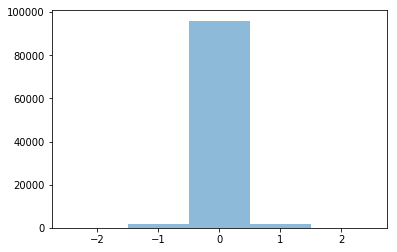

In [187]:
plt.hist(sen_majbpop_dp - sen_majbpop_sf, bins=np.arange(-2,4)-0.5, alpha=0.5)
plt.show()

In [102]:
sum(cong_majbpop_dp == 3)

3274

In [185]:
min(sen_majbpop_dp - sen_majbpop_sf)

-2

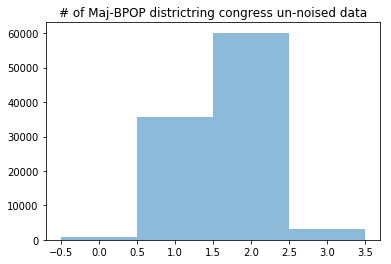

In [131]:
plt.title("# of Maj-BPOP districts with un-noised data")
plt.hist(cong_majbpop_sf, bins=np.arange(0,5)-0.5, alpha=0.5)
plt.show()

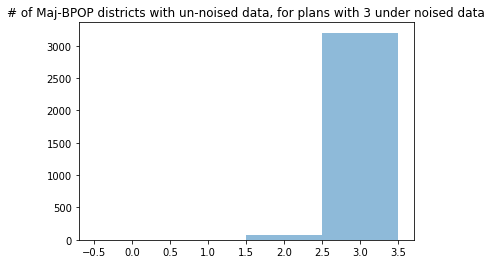

In [144]:
x = ma.compressed(ma.masked_where(cong_majbpop_dp != 3, cong_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 3 under noised data")
plt.hist(x, bins=np.arange(0,5)-0.5, alpha=0.5)
plt.show()

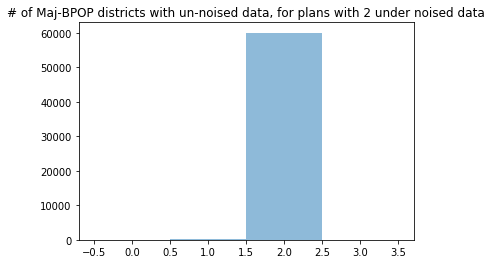

In [148]:
x = ma.compressed(ma.masked_where(cong_majbpop_dp != 2, cong_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 2 under noised data")
plt.hist(x, bins=np.arange(0,5)-0.5, alpha=0.5)
plt.show()

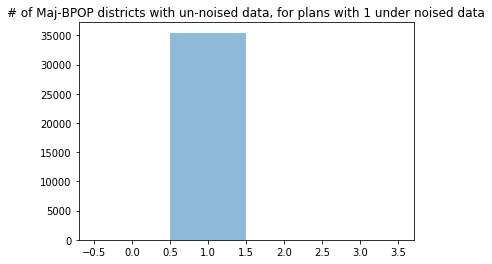

In [149]:
x = ma.compressed(ma.masked_where(cong_majbpop_dp != 1, cong_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 1 under noised data")
plt.hist(x, bins=np.arange(0,5)-0.5, alpha=0.5)
plt.show()

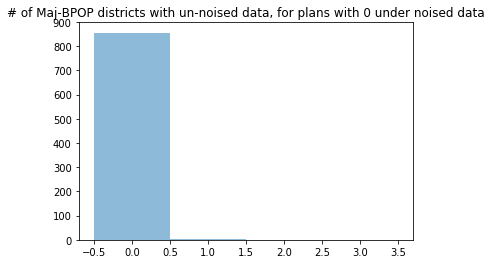

In [150]:
x = ma.compressed(ma.masked_where(cong_majbpop_dp != 0, cong_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 0 under noised data")
plt.hist(x, bins=np.arange(0,5)-0.5, alpha=0.5)
plt.show()

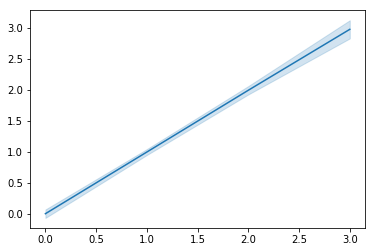

In [100]:
sns.lineplot(x = cong_majbpop_dp, y=cong_majbpop_sf, ci="sd")

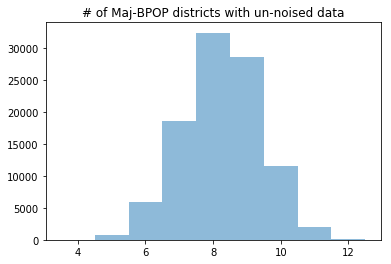

In [157]:
plt.title("# of Maj-BPOP districts with un-noised data")
plt.hist(sen_majbpop_sf, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

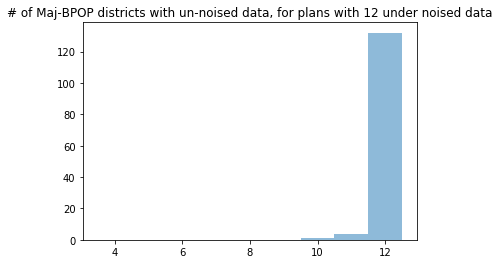

In [168]:
x = ma.compressed(ma.masked_where(sen_majbpop_dp != 12, sen_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 12 under noised data")
plt.hist(x, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

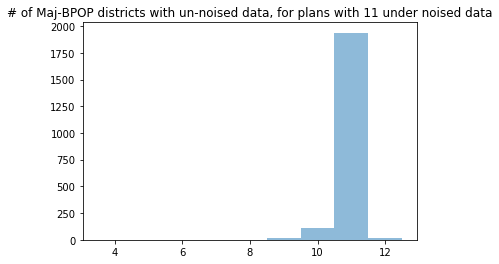

In [169]:
x = ma.compressed(ma.masked_where(sen_majbpop_dp != 11, sen_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 11 under noised data")
plt.hist(x, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

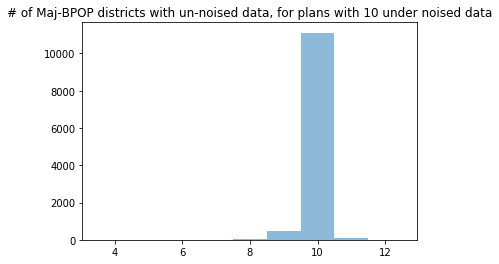

In [170]:
x = ma.compressed(ma.masked_where(sen_majbpop_dp != 10, sen_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 10 under noised data")
plt.hist(x, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

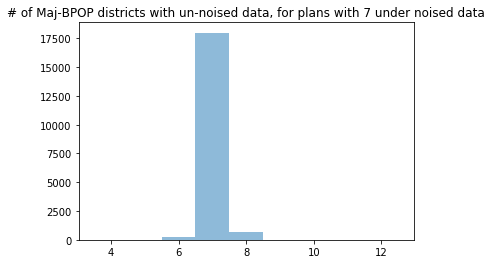

In [173]:
x = ma.compressed(ma.masked_where(sen_majbpop_dp != 7, sen_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 7 under noised data")
plt.hist(x, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

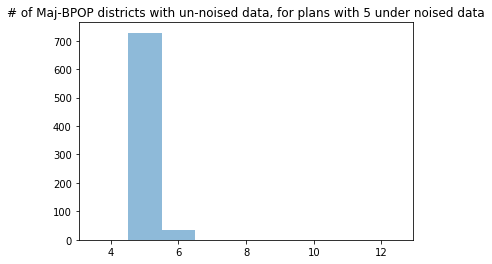

In [172]:
x = ma.compressed(ma.masked_where(sen_majbpop_dp != 5, sen_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 5 under noised data")
plt.hist(x, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

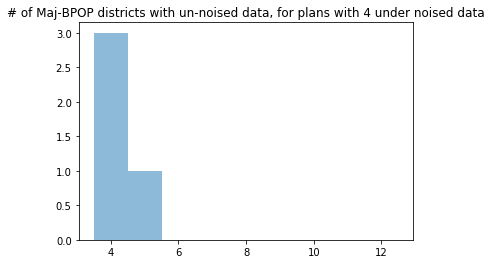

In [171]:
x = ma.compressed(ma.masked_where(sen_majbpop_dp != 4, sen_majbpop_sf))
plt.title("# of Maj-BPOP districts with un-noised data, for plans with 4 under noised data")
plt.hist(x, bins=np.arange(4,14)-0.5, alpha=0.5)
plt.show()

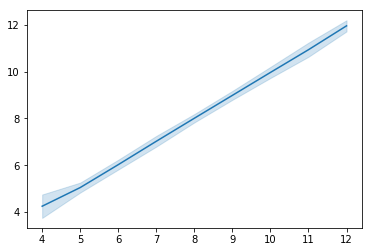

In [158]:
sns.lineplot(x = sen_majbpop_dp, y=sen_majbpop_sf, ci="sd")

## Distribution of plans

In [22]:
ITERS = 100000
CONG_DISTS = 14
SEN_DISTS = 56

In [27]:
d_cong = {"dist": np.array(list(np.arange(1,CONG_DISTS+1))*ITERS*2),
         "BPOP_perc": np.append(cong["BPOP_sf_perc"], cong["BPOP_dp_perc"]),
         "HPOP_perc": np.append(cong["HPOP_sf_perc"], cong["HPOP_dp_perc"]),
         "TOTPOP": np.append(cong["TOTPOP_sf"], cong["TOTPOP_dp"]),
         "type": np.repeat(np.array(["DP", "SF"]),ITERS*CONG_DISTS)}

d_sen = {"dist": np.array(list(np.arange(1,SEN_DISTS+1))*ITERS*2),
         "BPOP_perc": np.append(sen["BPOP_sf_perc"], sen["BPOP_dp_perc"]),
         "HPOP_perc": np.append(sen["HPOP_sf_perc"], sen["HPOP_dp_perc"]),
         "TOTPOP": np.append(sen["TOTPOP_sf"], sen["TOTPOP_dp"]),
         "type": np.repeat(np.array(["DP", "SF"]),ITERS*SEN_DISTS)}

In [28]:
df_cong = pd.DataFrame(d_cong)
df_sen = pd.DataFrame(d_sen)

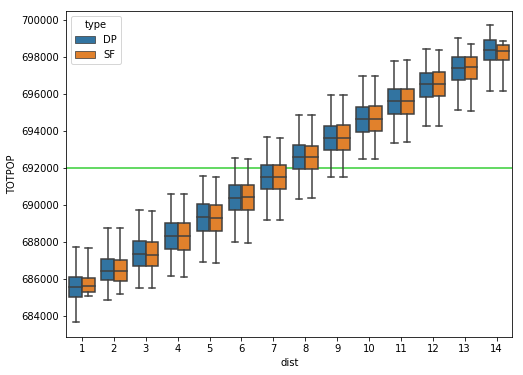

In [63]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_cong, x="dist", y="TOTPOP", hue="type", showfliers=False, whis=(1,99))
plt.axhline(y=total_pop / CONG_DISTS, color="limegreen", zorder=0)
plt.show()

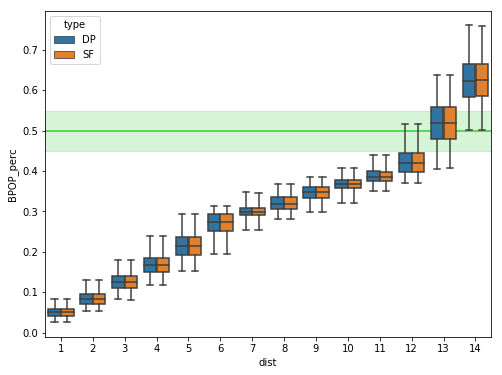

In [69]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_cong, x="dist", y="BPOP_perc", hue="type", showfliers=False, whis=(1,99))
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.axhspan(ymin=0.45, ymax=0.55, color="limegreen", zorder=0, alpha=0.2)

plt.show()

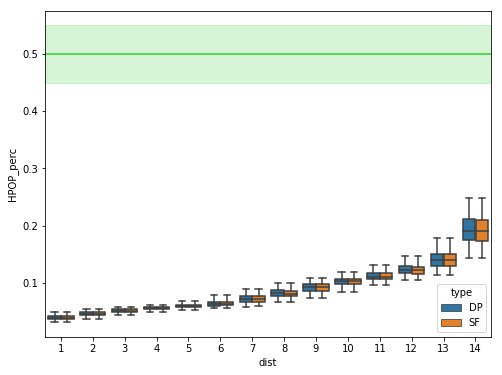

In [70]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_cong, x="dist", y="HPOP_perc", hue="type", showfliers=False, whis=(1,99))
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.axhspan(ymin=0.45, ymax=0.55, color="limegreen", zorder=0, alpha=0.2)
plt.show()

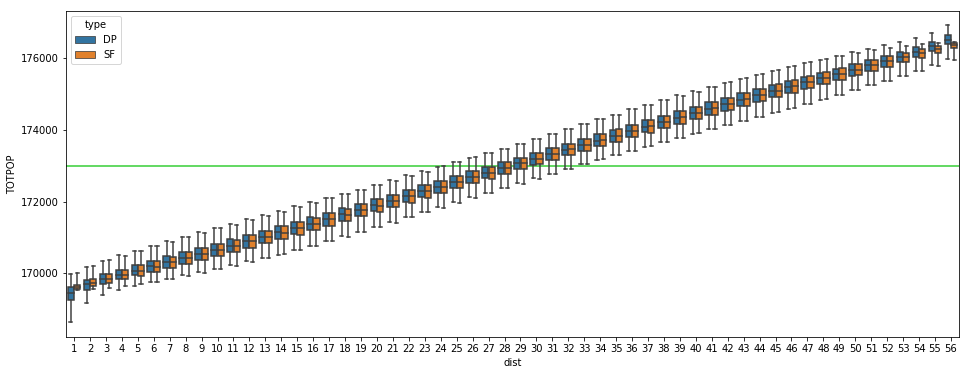

In [61]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df_sen, x="dist", y="TOTPOP", hue="type", showfliers=False, whis=(1,99))
plt.axhline(y=total_pop / SEN_DISTS, color="limegreen", zorder=0)
plt.show()

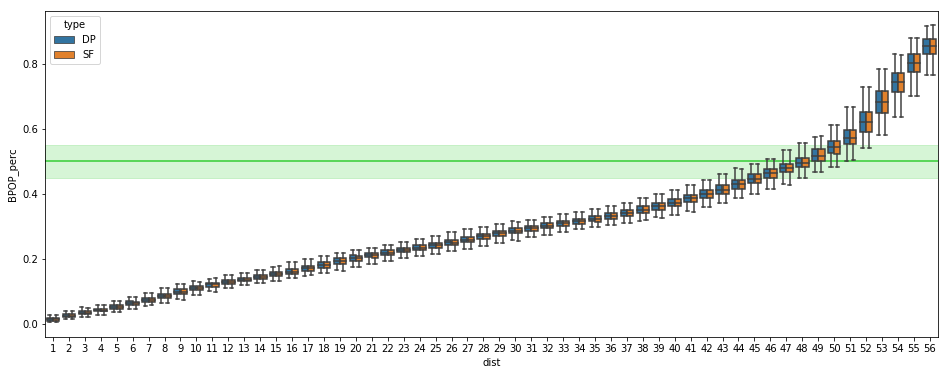

In [71]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df_sen, x="dist", y="BPOP_perc", hue="type", showfliers=False, whis=(1,99))
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.axhspan(ymin=0.45, ymax=0.55, color="limegreen", zorder=0, alpha=0.2)
plt.show()

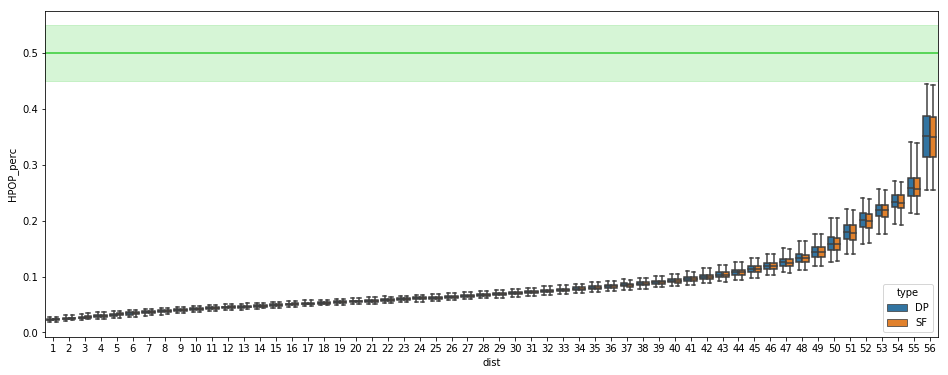

In [72]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df_sen, x="dist", y="HPOP_perc", hue="type", showfliers=False, whis=(1,99))
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.axhspan(ymin=0.45, ymax=0.55, color="limegreen", zorder=0, alpha=0.2)
plt.show()